# Count By Segmentation: Validating Baseline on the Multicondition Dataset

This note validates the model of `baseline.ipynb` on the `multicondition` dataset.

In [1]:
VERSION = 105

In [2]:
import sys, importlib

sys.path.append("../..")

%matplotlib inline

# Dataset

We will use the `multicondition` dataset.

All images are $4048px \times 3036px$ and RGB.

Each example in the `multicondition` dataset is dervied from a single plate and consists of:
1. an image of the plate, well-lit, uncovered, from far away (the plate fills about $1/3$ of the shorter dimension of the image), with no perspective (looking straight down at the plate)
2. an image of the plate, well-lit, covered, close-up (the plate fills about $3/4$ of the shorter dimension of the image), with severe perspective
3. an image of the plate, fairly well-lit, uncovered, close-up (the plate fills about $3/4$ of the shorter dimension of the image), with minor perspective

In [4]:
from src import dataset
importlib.reload(dataset)
import numpy as np

DATA_PATH = "data"
CONDITION_STRINGS = (
    "light_covered_close_severeperspective",
    "light_uncovered_far_noperspective",
    "nolight_uncovered_close_minorperspective"
)

def make_transform(condition_string):
    def transform(aspects):
        inp = np.stack((aspects[condition_string + "_red"], aspects[condition_string + "_green"], aspects[condition_string + "_blue"]), axis=2)
        out = aspects["count"]
        return inp, out
    return transform

datasets = {}
for condition_string in CONDITION_STRINGS:
    datasets[condition_string] = dataset.Dataset("data/{0:d}/{1:s}".format(VERSION, condition_string), 1)
    datasets[condition_string].initialize_from_aspects("../../data/multicondition/data", make_transform(condition_string))

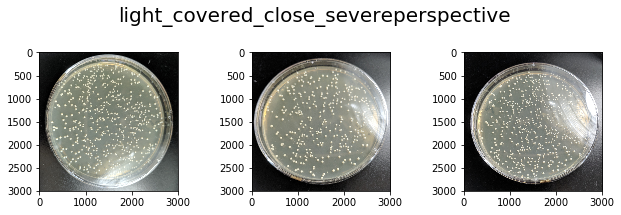

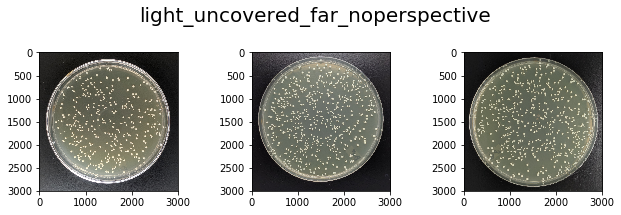

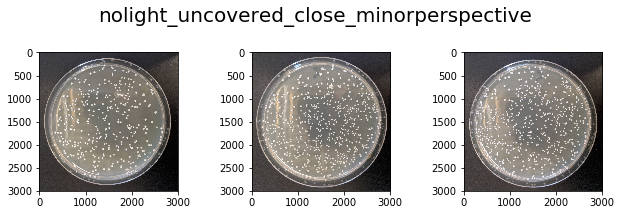

In [5]:
from src import visualization
importlib.reload(visualization)

NUM_IMAGES = 3
GRID_COLS = 3
IMAGE_SIZE = (3, 3)

for cond, data in datasets.items():
    images, _ = data.get_batch(NUM_IMAGES)
    visualization.plot_images(images, GRID_COLS, IMAGE_SIZE, cond)

# Model

Now we load the saved model.

In [6]:
from models.segmentation.convnet1 import convnet1
importlib.reload(convnet1)

SAVE_INTERVAL = 5

model = convnet1.ConvNet1("model/1", SAVE_INTERVAL, 0)

# Testing

Lastly, we test the model's ability to produce counts for the plate images in the dataset.

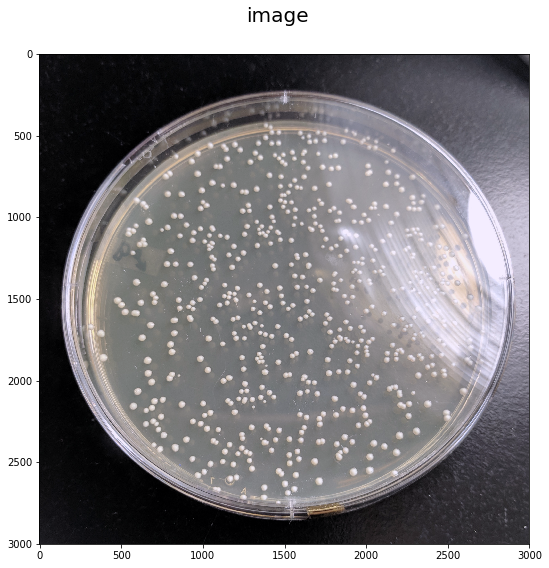

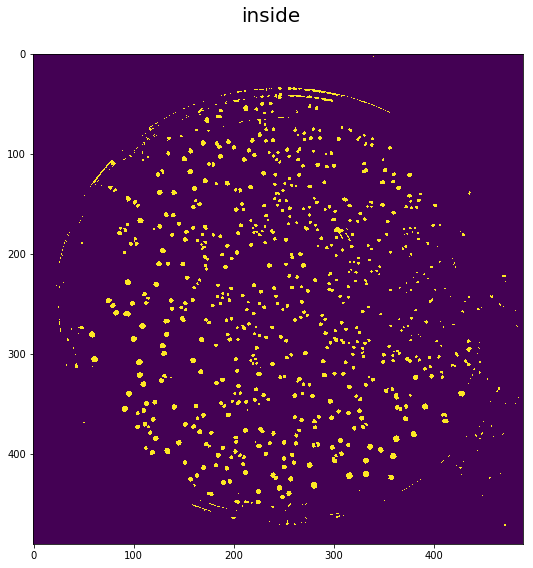

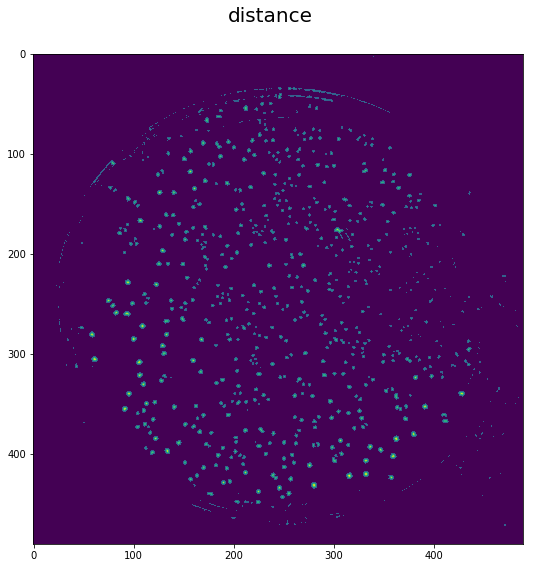

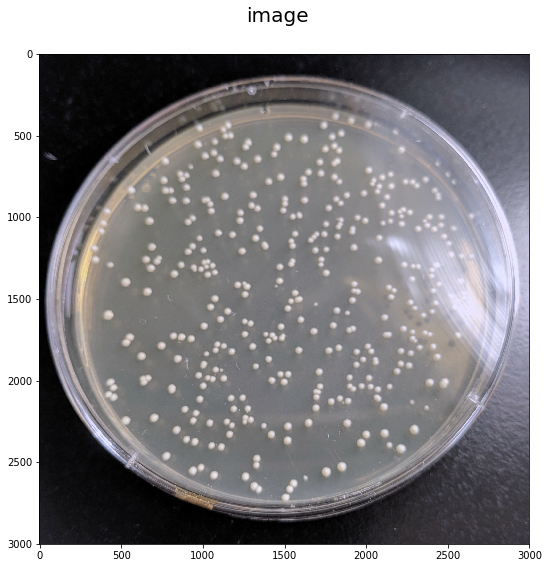

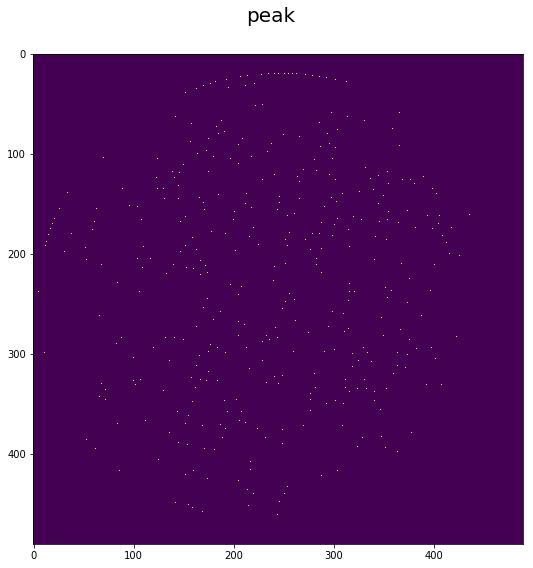

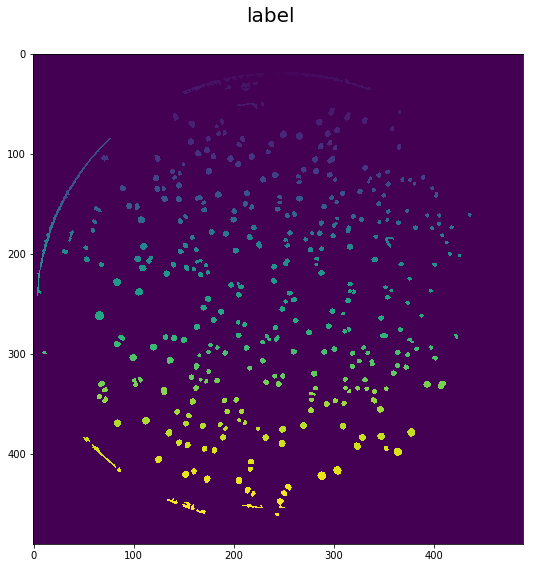

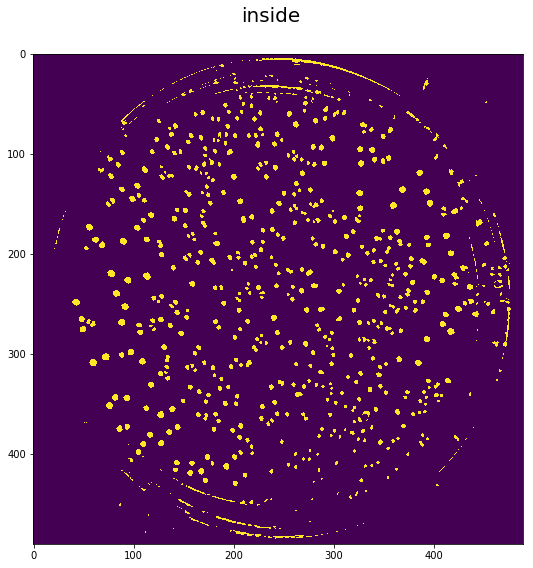

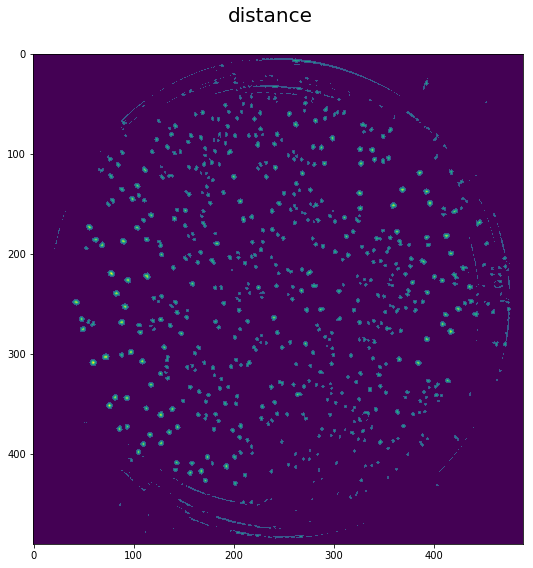

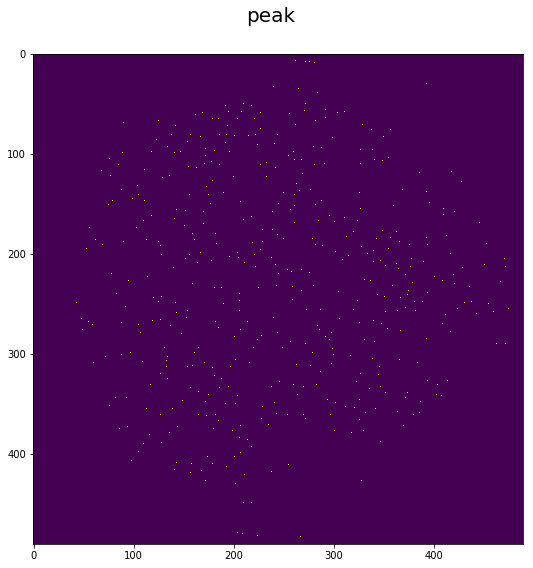

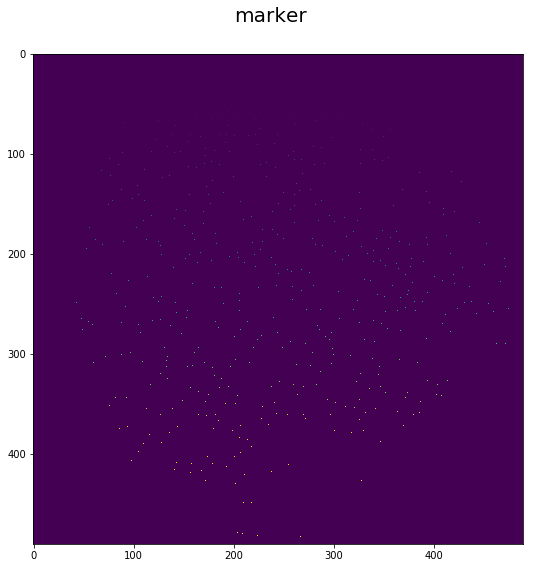

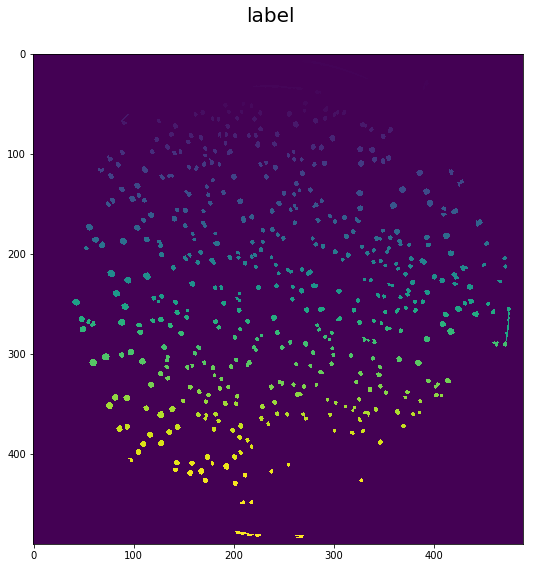

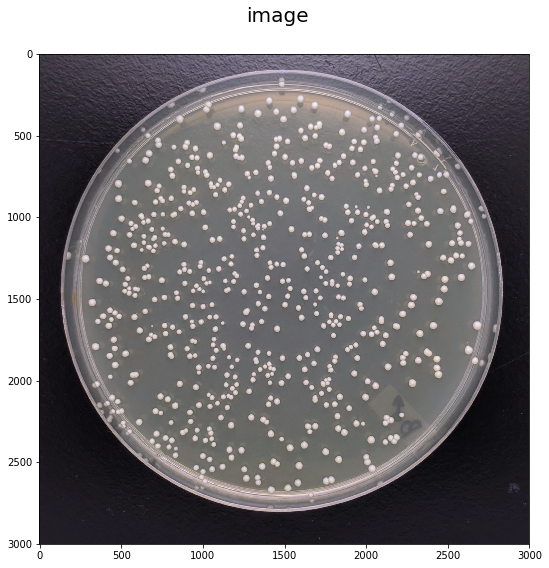

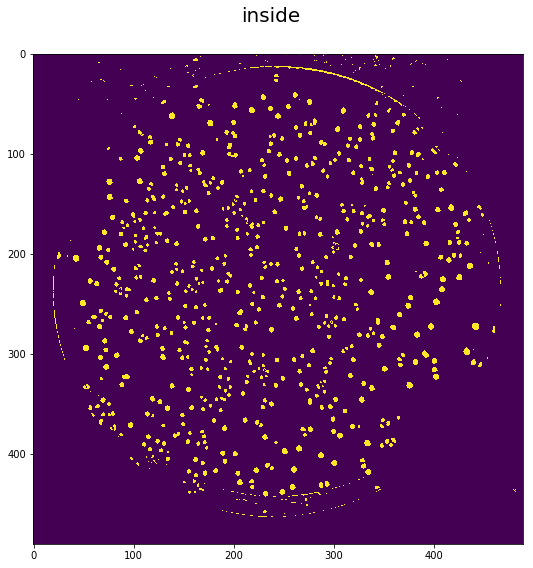

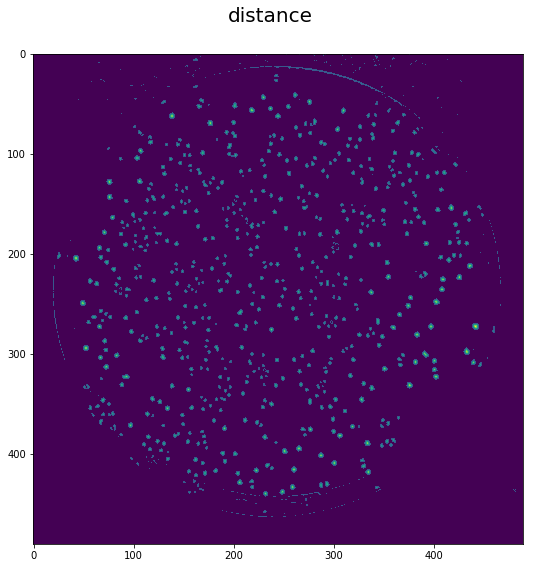

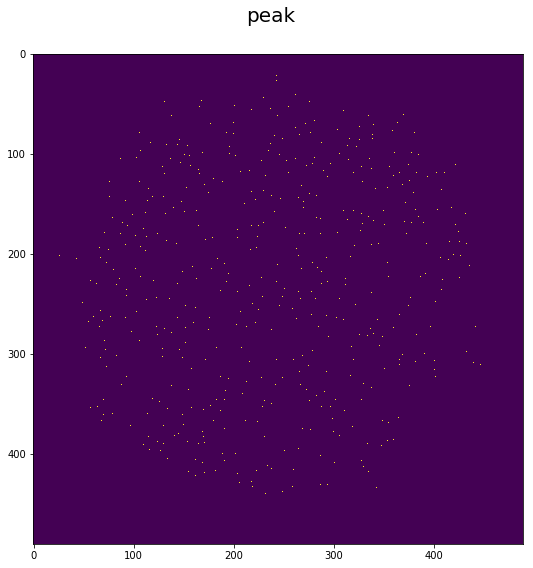

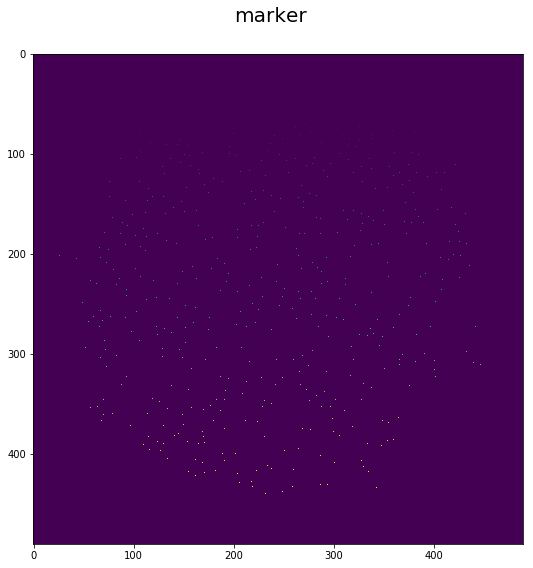

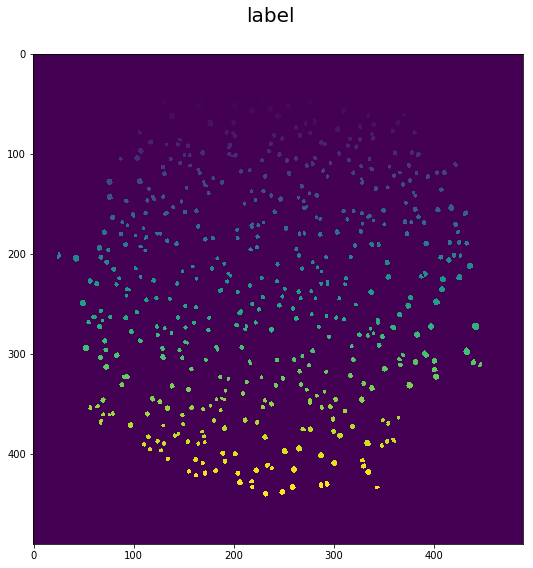

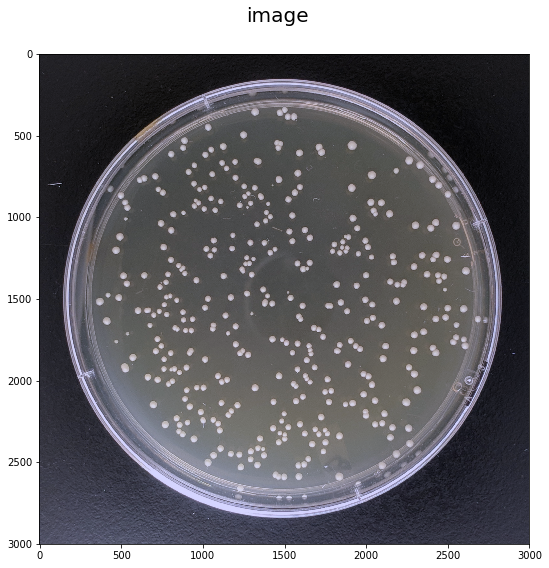

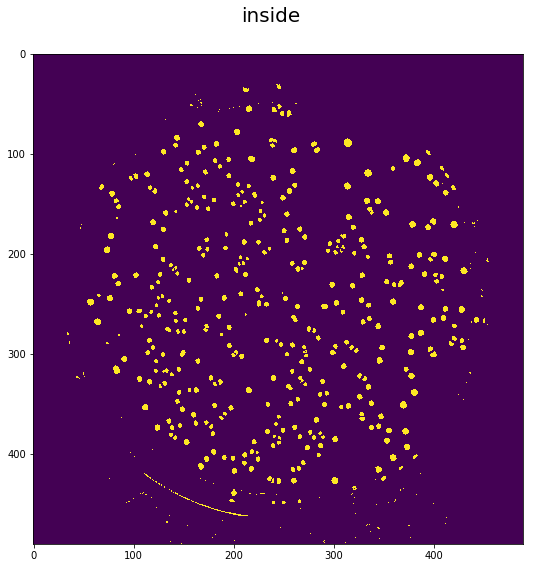

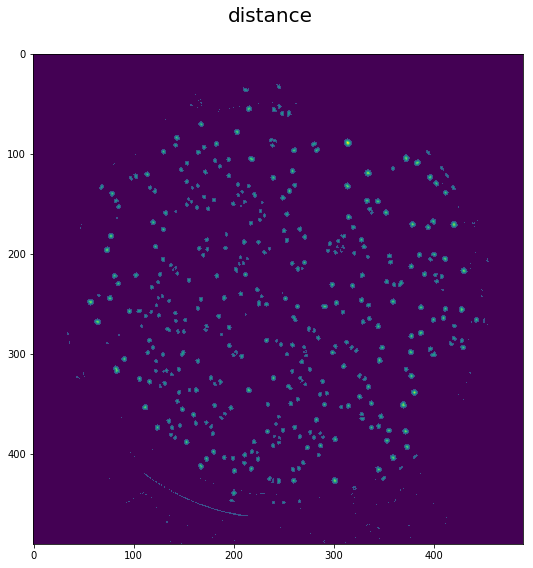

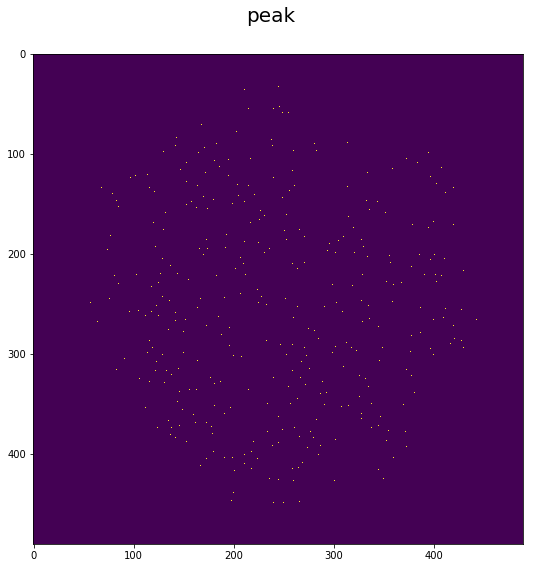

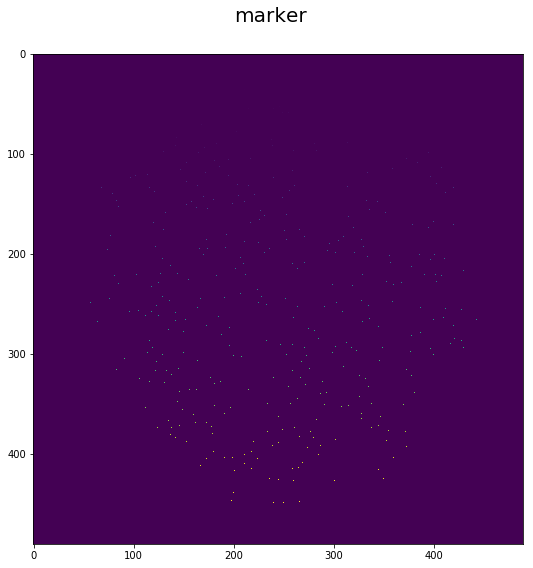

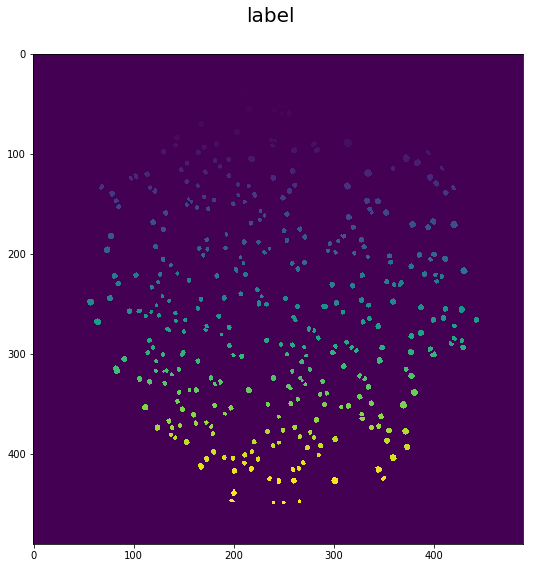

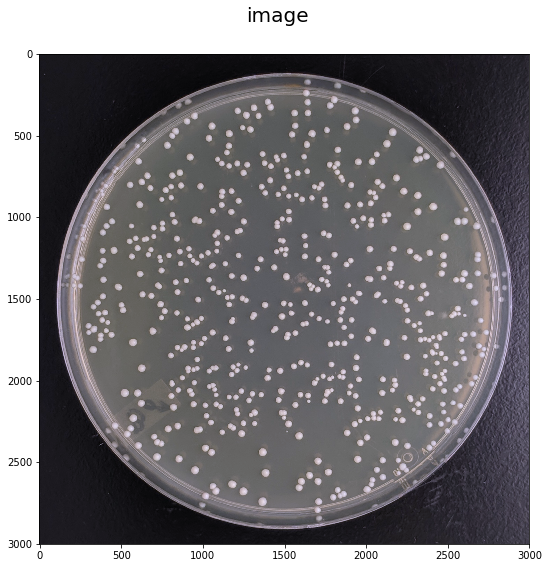

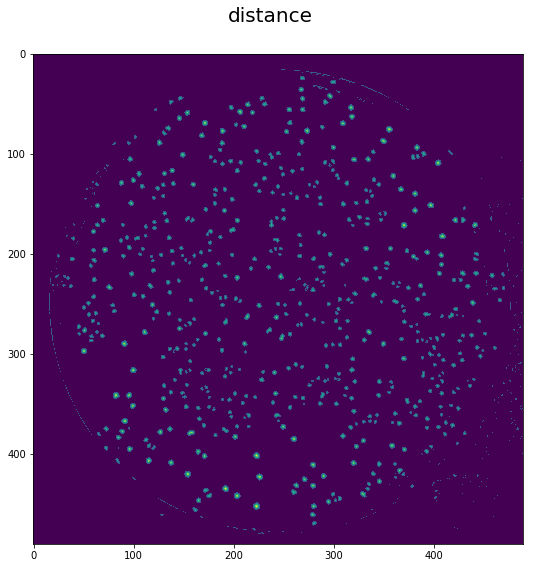

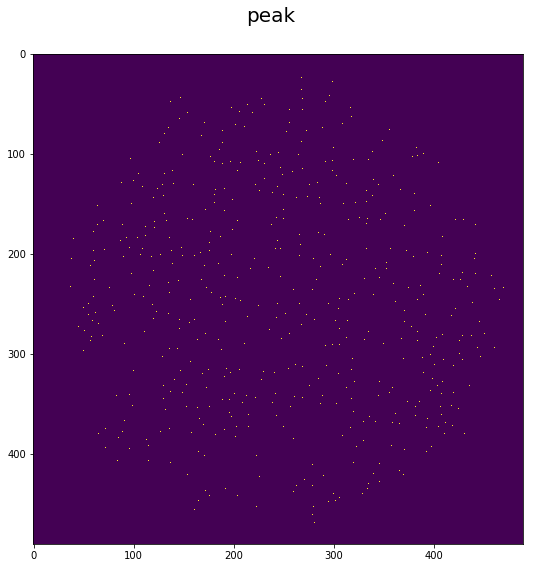

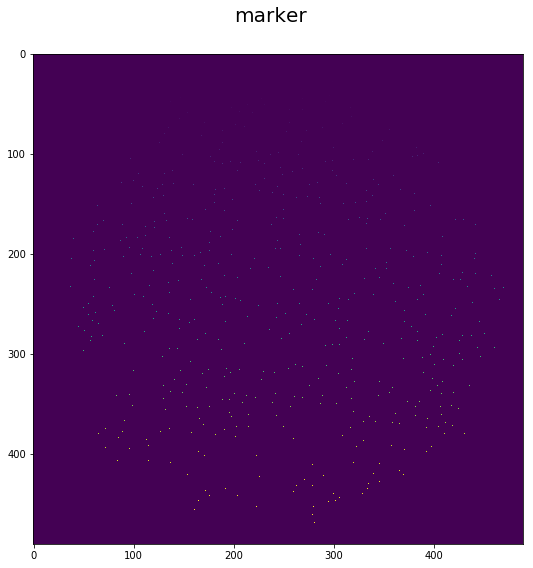

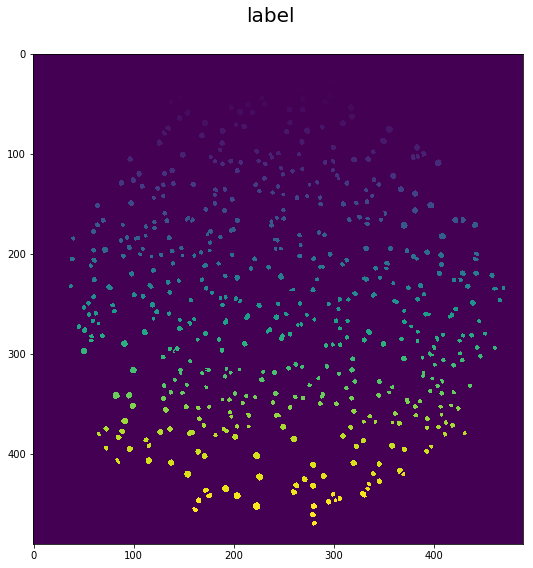

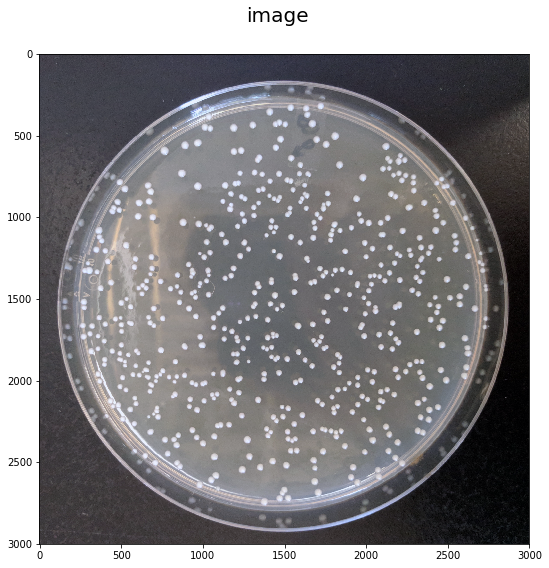

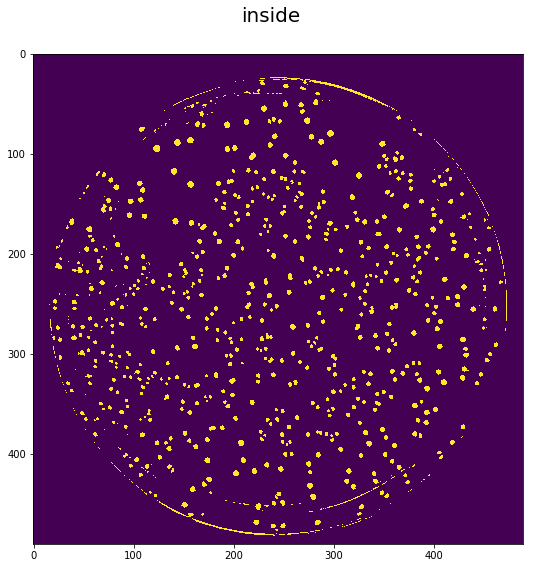

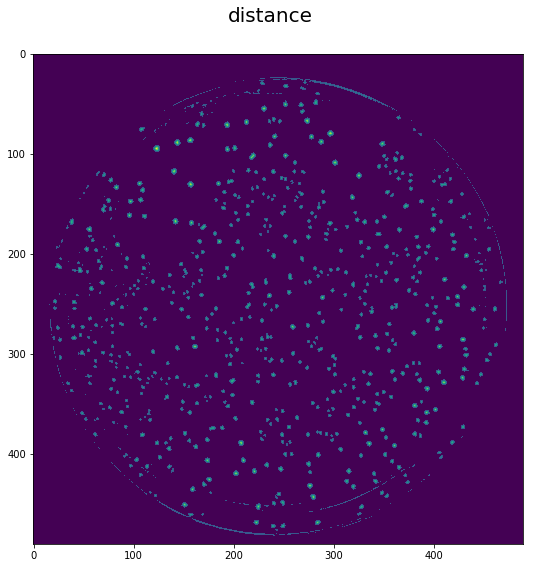

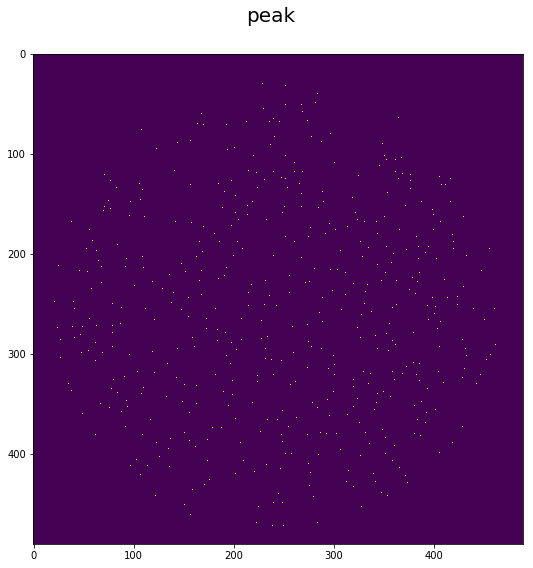

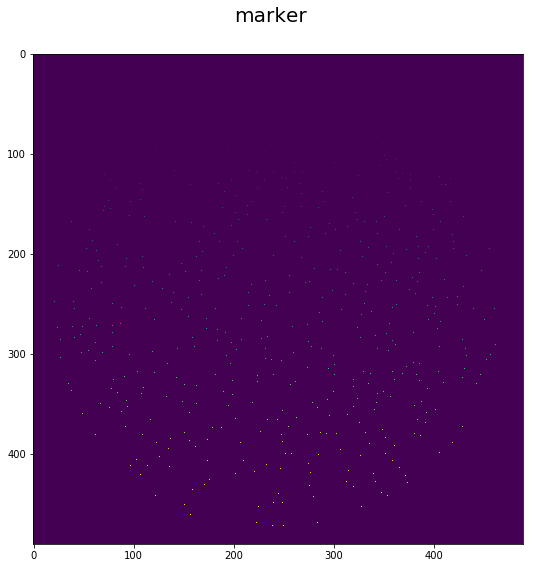

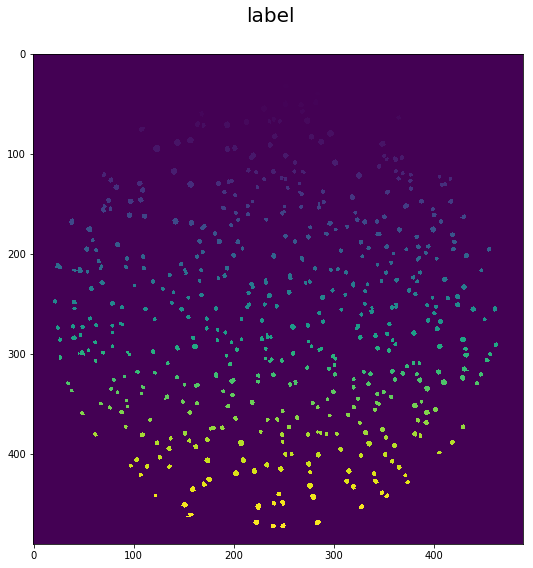

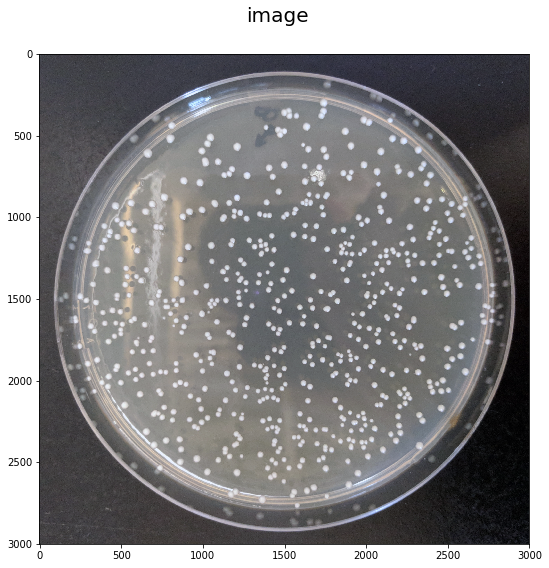

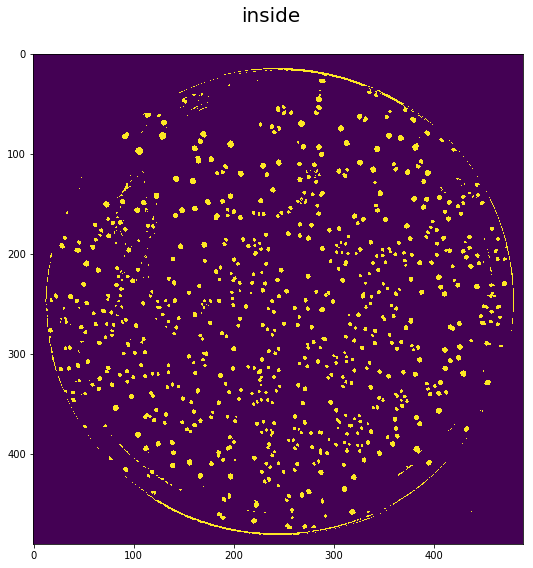

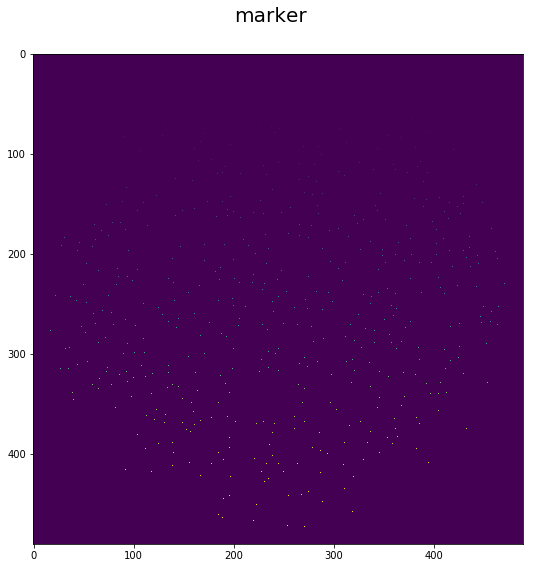

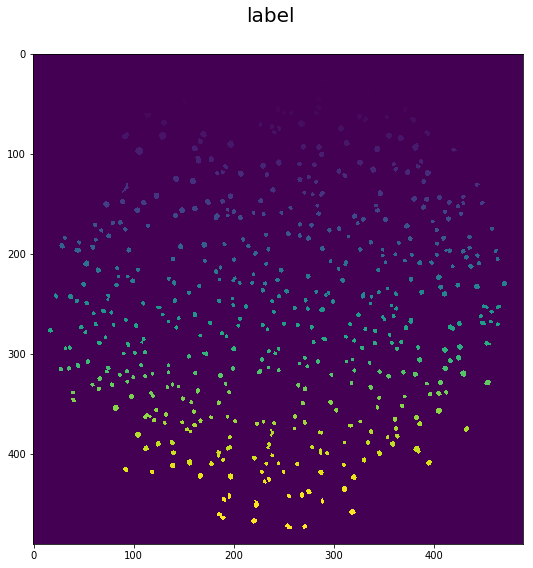

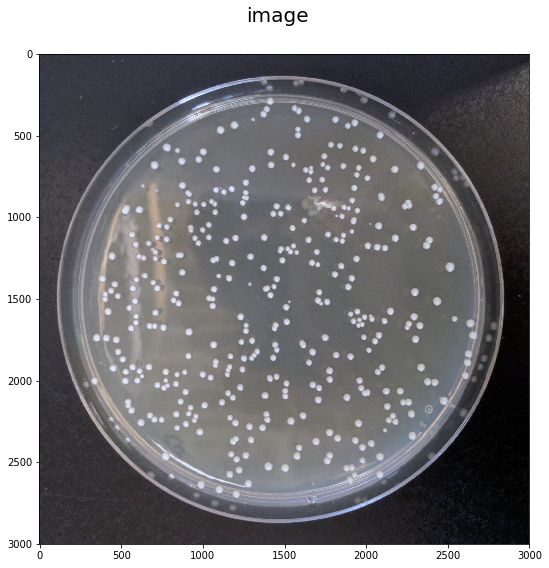

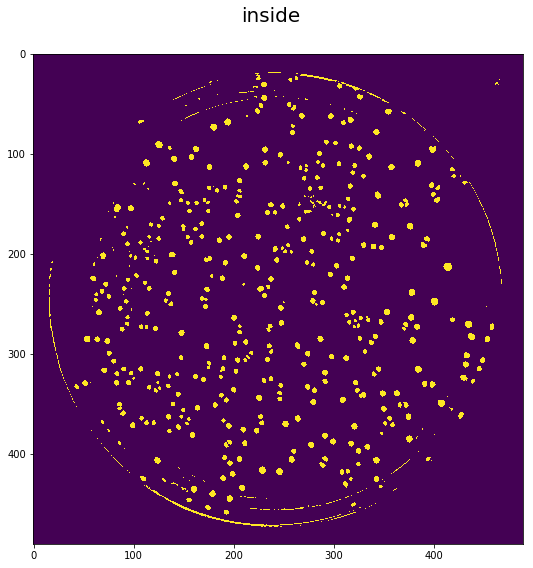

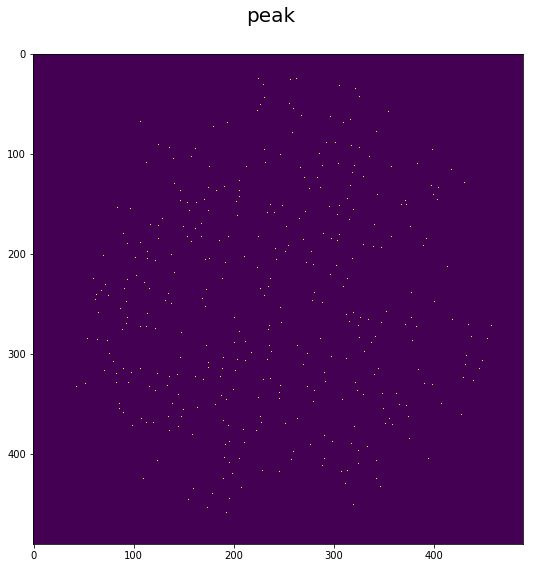

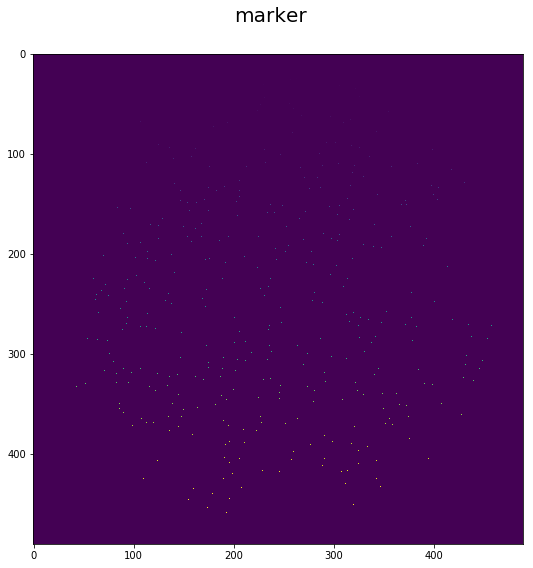

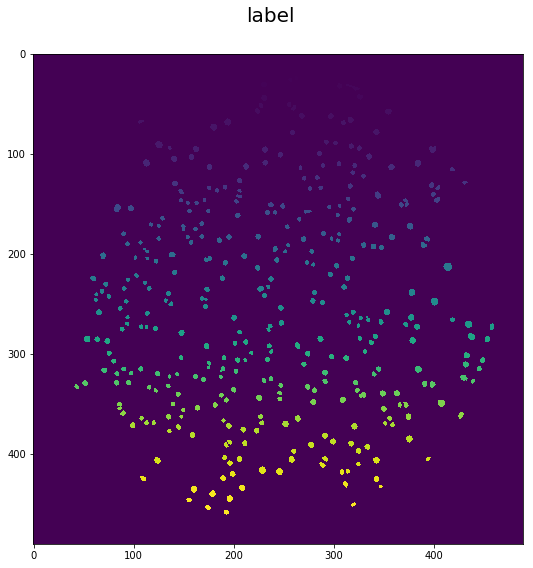

In [17]:
from src import preprocess
importlib.reload(preprocess)
from src import postprocess
importlib.reload(postprocess)
import math
from scipy import ndimage, misc
import numpy as np

MIN_COLONY_DIAM = 20
IMAGE_WIDTH = 3_000
PATCH_SIZE = 61
PATCH_BATCH_SIZE = 3_000
IMAGE_BATCH_SIZE = 3
COUNT_RESIZE_WIDTH = 500 # CHANGE ME

count_resize_sampling_interval = int(IMAGE_WIDTH / COUNT_RESIZE_WIDTH)
min_dist = max(1, int(MIN_COLONY_DIAM / count_resize_sampling_interval))
min_diam = MIN_COLONY_DIAM / count_resize_sampling_interval

actual_counts = {}
predicted_counts = {}

def patch_classifier(patches):
    patches = preprocess.subtract_mean_normalize(patches)
    scores = model.predict(patches)
    return scores

for cond, data in datasets.items():
    actual_counts[cond] = []
    predicted_counts[cond] = []
    images, counts = data.get_batch(IMAGE_BATCH_SIZE)
    images = preprocess.divide_median_normalize(images)
    for i in range(images.shape[0]):
        actual_counts[cond].append(counts[i])
        predicted_count = postprocess.count_regions(images[i, ...], PATCH_SIZE, patch_classifier, PATCH_BATCH_SIZE, min_dist, min_diam, sampling_interval=count_resize_sampling_interval, debug=True)
        predicted_counts[cond].append(predicted_count)

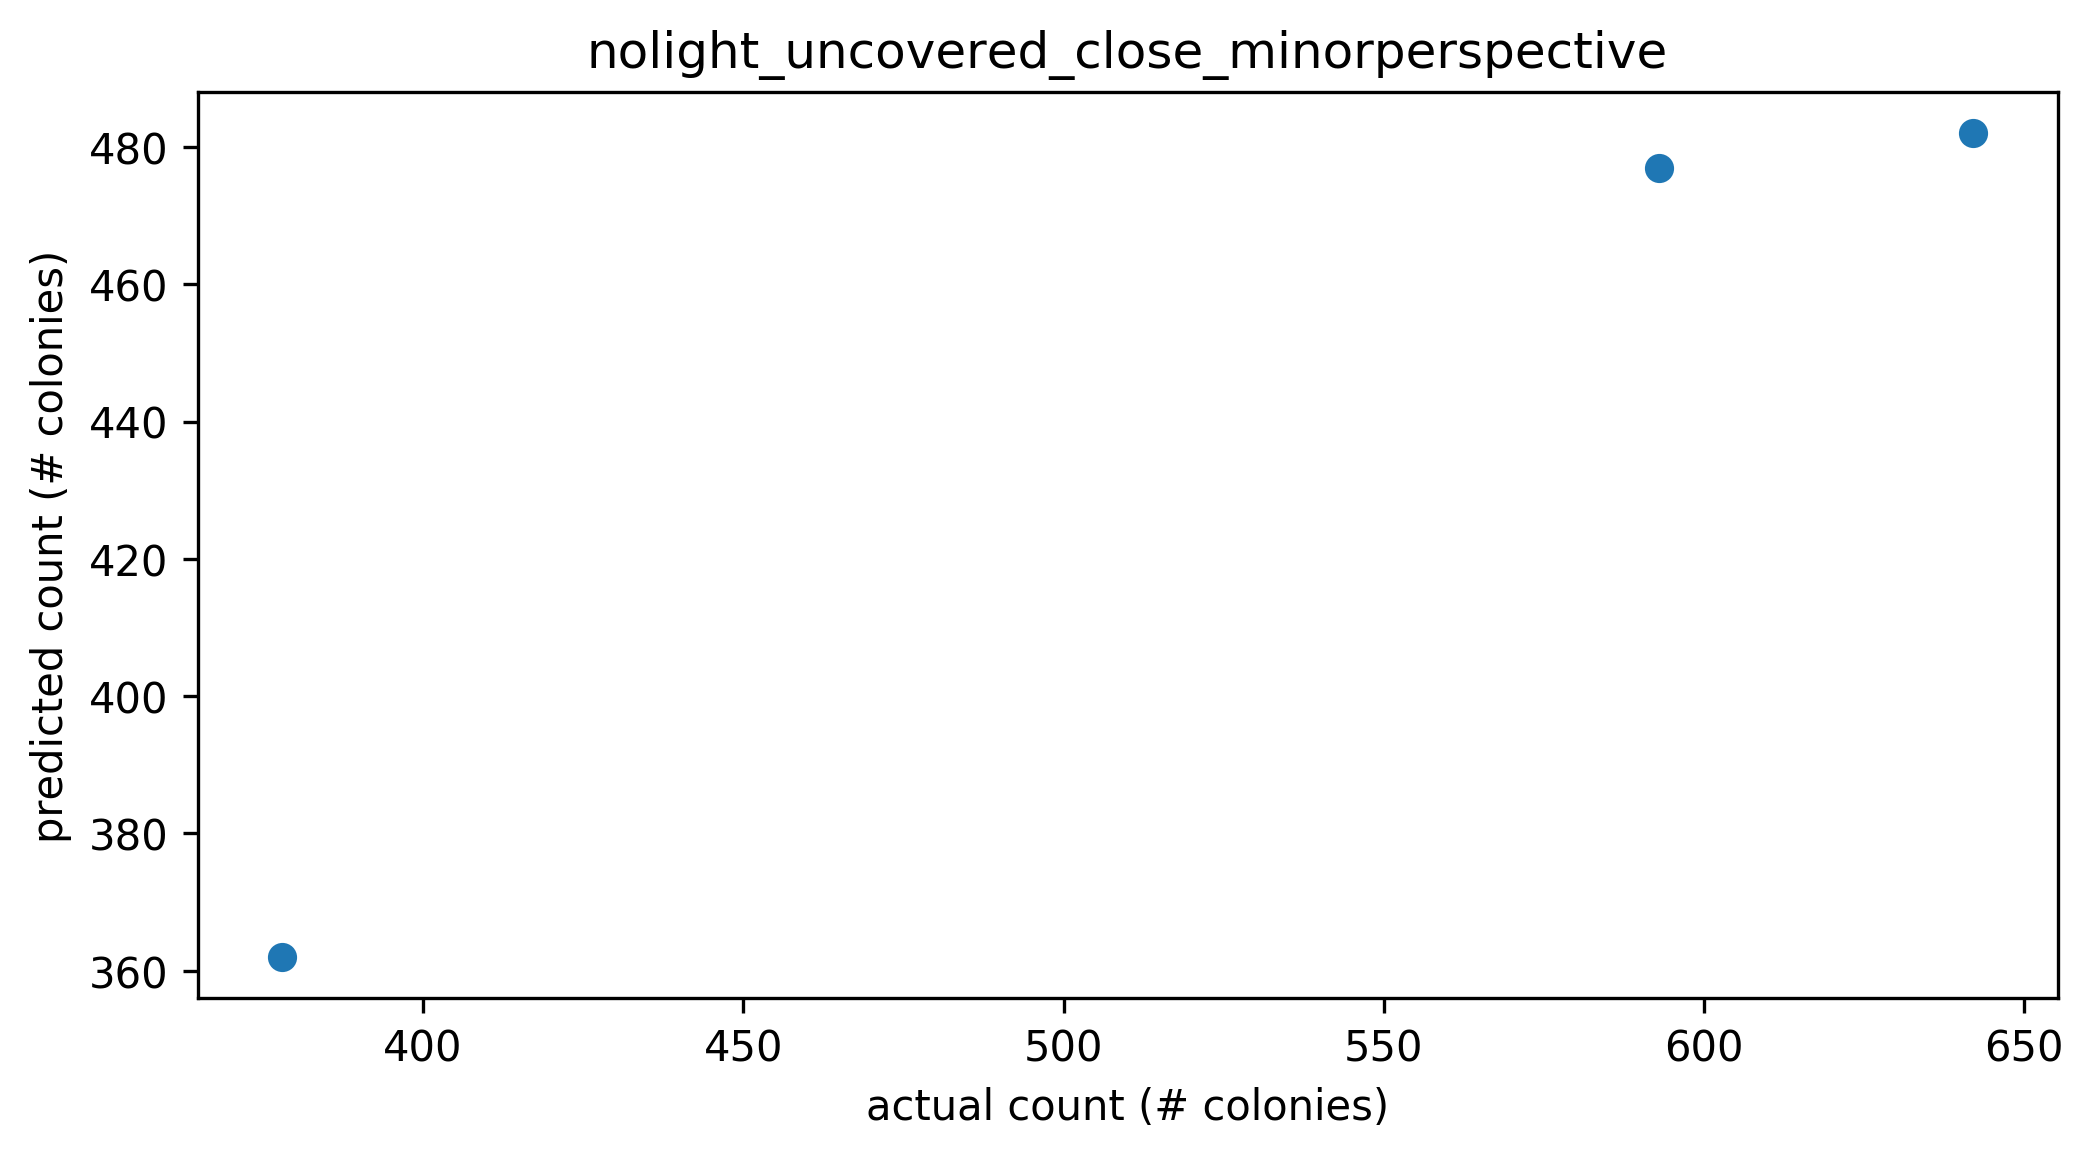

In [18]:
from src import visualization
importlib.reload(visualization)

for cond in datasets:
    xs, ys = actual_counts[cond], predicted_counts[cond]
    visualization.plot_scatter(xs, ys, cond, "actual count (# colonies)", "predicted count (# colonies)", 4, 8)